In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical as emp

import backtrader as bt
import datetime
import csv
import math
import os, sys

from ast import literal_eval
plt.rcParams['font.family'] = ['Heiti TC']

In [2]:
class Logger:
    """将输出内容保存到本地文件"""

    def __init__(self, filename="trades.log"):
        self.terminal = sys.stdout
        self.log = open(filename, "w")

    def write(self, msg):
        self.terminal.write(msg)
        self.log.write(msg)

    def flush(self):
        pass


class MetaVar:

    valid_contracts = ["IF00", "IH00", "IC00"]

    def __init__(self, contract: str):
        # 合约设置
        if contract in self.valid_contracts:
            self.contract = contract
        else:
            print("Invalid contract name...")

        # 回测区间设置
        self.fromdate = datetime.datetime(2010, 4, 16)
        self.todate = datetime.datetime(2014, 12, 31)

        # 回测周期设置  ==待优化==
        self.period = 14
        self.window = 9

        # 交易时间表
        # filepath = os.path.join(os.curdir, 'trading_time', self.contract + '_time.csv')  # 5min data
        filepath = os.path.join(os.path.abspath("."), "trading_time", self.contract + "_1mtime.csv")  # 1min data
        self.time_df = pd.read_csv(filepath, index_col="date")

        # 初始资金设置
        self.startcash = 10_000_000

        # 交易手续费设置
        self.closeout_type = 1  # 1代表平今仓，0代表止盈止损平仓

        # 保证金设置
        if self.contract in ["IH00", "IC00"]:
            self.margin = 0.10
        elif self.contract == "IF00":
            self.margin = 0.12

        # 乘数设置
        if self.contract in ["IF00", "IH00"]:
            self.mult = 300.0
        elif self.contract == "IC00":
            self.mult = 200.0

        # 滑点设置

        # 印花税设置
        self.stamp_duty = 0.001


var = MetaVar("IF00")


## 策略主体 

定义日内1分钟收盘价格序列为$p(t),\ t=1, 2, 3...$  
均线参数为N，移动平均线为
$$\hat p(t)=MA(p,N)$$

噪声
$$\epsilon(t)=p(t)-\hat p(t)$$

定义噪声积量（窗口大小为L）
$$S_L(t)=\sum_{i=0}^{L-i}\epsilon(t-i)$$

噪声的移动标准差为
$$\sigma(t)=\sqrt{\sum_{i=0}^{N-1}[p(t-i)-\hat p(t)]^2/(N-1)}$$

噪声累积标准差
$$\Sigma_L(t)=\sqrt{\sum_{i=0}^{L-1}\sigma^2(t-i)}$$


In [3]:
class CumNoise(bt.Strategy):
    params = dict(
        period=var.period,  # 移动平均区间
        window=var.window,  # 累积窗口
        close_limit=0.02,  # 平仓限额
        target_percent=0.30,  # 目标订单比例
    )

    def __init__(self):
        # 常用数据
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datadatetime = self.datas[0].datetime

        self.buy_price = self.sell_price = None
        self.buy_create = self.sell_create = None

        # 订单记录
        self.orefs = []
        self.order = None

        # 控制下单时间
        self.ordermin = None

    def log(self, txt, dt=None):
        dt = dt or self.datadatetime.datetime(0)
        print(dt, txt)

    def notify_order(self, order):
        """下订单后显示"""
        # 不处理已提交或已接受的订单
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 处理已完成订单
        if order.status == order.Completed:
            # 保证金占用
            margin_used = order.executed.price * abs(order.executed.size) * var.mult * var.margin

            if order.isbuy():
                # 记录订单完成时间
                self.ordermin = bt.num2time(self.datadatetime[0]).isoformat()
                self.log(f"LONG SIG DETECTED @ {order.created.price:.2f}")
                self.log(
                    f"BUY EXECUTED {order.executed.price:.2f}, SIZE {order.executed.size:.2f}, COST {order.executed.value:.2f}, COMMISSION {order.executed.comm:.2f}, MARGIN {margin_used:.2f}"
                )

                if order.info:
                    self.log(f"INFO {order.info['name']}")

                self.buy_price = order.executed.price

            elif order.issell():
                self.ordermin = bt.num2time(self.datadatetime[0]).isoformat()
                self.log(f"SHORT SIG DETECTED @ {order.created.price:.2f}")
                self.log(
                    f"SELL EXECUTED {order.executed.price:.2f}, SIZE {order.executed.size:.2f}, COST {order.executed.value:.2f}, COMMISSION {order.executed.comm:.2f}, MARGIN {margin_used:.2f}"
                )

                if order.info:
                    self.log(f"INFO {order.info['name']}")

                self.sell_price = order.executed.price

            self.bar_executed = len(self)

        # 处理问题清单
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f"ORDER CANCELED/MARGIN/REJECTED **CODE**: {order.getstatusname()}")

        self.order = None

    def notify_trade(self, trade):
        """平仓后显示"""
        if not trade.isclosed:
            return
        self.log(f"OPERATION PROFIT {trade.pnl:.2f}, NET PROFIT {trade.pnlcomm:.2f}")

    def start(self):
        """开始前运行"""
        # Observers数据写入本地文件
        self.mystats = csv.writer(open("results.csv", "w"))
        self.mystats.writerow(
            [
                "datetime",
                "drawdown",
                "maxdrawdown",
                "timereturn",
                "value",
                "cash",
                "buy",
                "sell",
                "pnlplus",
                "pnlminus",
            ]
        )

    def next(self):
        """回测开始后的每个bar运行"""
        # 当天的交易时间段
        today = bt.num2date(self.datadatetime[0]).date()
        trading_period = literal_eval(self.get_tradetime(today).values[0])
        open_time = trading_period[0]  # open price for stoplimit
        close_time = trading_period[-2]  # 在收盘前一个bar发出平仓信号
        now = bt.num2time(self.datadatetime[0]).isoformat()

        # 记录开盘价
        if now == open_time:
            self.dayopen = self.dataopen[0]

        # 符合一下任一条件时跳过当前交易日
        bypass_conds = [
            self.order,  # 存在正在进行中的订单
            now == self.ordermin,  # 防止重复下单
            len(self) < var.period + var.window,  # 在此之前无法计算累积量
        ]
        if any(bypass_conds):
            return

        # 计算交易信号
        # 噪声累积量
        cum_noise = self.get_cum_noise(self.dataclose, self.p.period, self.p.window)

        # 累积量标准差
        cum_noise_std = math.sqrt(
            math.fsum([self.get_moving_std(i, self.dataclose, self.p.period) ** 2 for i in range(self.p.window)])
        )

        # +/- 2x std
        long_sig = cum_noise > 2 * cum_noise_std
        short_sig = cum_noise < -2 * cum_noise_std

        # 下订单
        var.closeout_type = 0
        # 平今仓
        if now == close_time and self.position:
            var.closeout_type = 1
            self.order = self.close()
            self.order.addinfo(name="CLOSE OUT AT THE END OF DAY")
        else:
            # 开仓逻辑
            if not self.position:
                if long_sig:
                    self.order = self.order_target_percent(target=self.p.target_percent)
                elif short_sig:
                    self.order = self.order_target_percent(target=-self.p.target_percent)
            # 平仓逻辑
            else:
                pct_change = self.dataclose[0] / self.dayopen - 1
                cur_pos = self.broker.getposition(data=self.datas[0]).size
                long_close_sig = cur_pos > 0 and (pct_change < -self.p.close_limit)  # 持有多头且下跌超过阈值
                short_close_sig = cur_pos < 0 and (pct_change > self.p.close_limit)  # 持有空头且上涨超过阈值

                if long_close_sig or short_close_sig:
                    self.order = self.order_target_percent(target=0)  # 0表示为平仓
                    self.order.addinfo(name="CLOSE OUT DUE TO STOPLIMIT")

        # 将交易数据写入本地文件
        self.write_obs(-1)

    def stop(self):
        """回测结束后的最后一个bar运行"""
        self.write_obs(0)

    def get_tradetime(self, today):
        """获取当日所有交易时间点"""
        return var.time_df.loc[today.isoformat()]

    def get_cum_noise(self, data, nper, window):
        """
        计算当天时间点收盘价的累积噪声量

        Params
        ------
        data: 收盘价序列
        nper: 移动平均区间
        window: 累积噪声量区间
        """
        cum_noise = 0
        for t in range(window):
            sma = math.fsum(data.get(ago=-t, size=nper)) / nper
            if sma == 0:  # no sma because of lacking data
                noise = 0
            else:
                noise = data[-t] - sma
            cum_noise += noise

        return cum_noise

    def get_moving_std(self, t, data, nper):
        """
        计算t时间点下噪声的移动标准差

        Params
        ------
        t: 当前返回结果基于前t个时间点
        data: 收盘价序列
        nper: 移动平均的周期
        """
        return np.std(data.get(ago=-t, size=nper), ddof=1)

    def write_obs(self, t):
        self.mystats.writerow(
            [
                self.datadatetime.datetime(t).strftime("%Y-%m-%d %H:%M:%S"),
                f"{self.stats.drawdown.drawdown[0]:.2f}",
                f"{self.stats.drawdown.maxdrawdown[0]:.2f}",
                f"{self.stats.timereturn.timereturn[0]:.2f}",
                f"{self.stats.broker.value[0]:.2f}",
                f"{self.stats.broker.cash[0]:.2f}",
                f"{self.stats.buysell.buy[0]:.2f}",
                f"{self.stats.buysell.sell[0]:.2f}",
                f"{self.stats.trades.pnlplus[0]:.2f}",
                f"{self.stats.trades.pnlminus[0]:.2f}",
            ]
        )


In [4]:

class FurCommInfo(bt.CommInfoBase):
    """定义期货的交易手续费和佣金"""

    params = dict(
        stocklike=False,
        commtype=bt.CommInfoBase.COMM_PERC,  # 按比例收取手续费
        percabs=True,  # 0.0002 = 0.2%
        commission=3.45 / 10000,
        mult=var.mult,
        stamp_duty=var.stamp_duty,
        margin=var.margin,
    )

    def _getcommission(self, size, price, pseudoexec=True):
        """
        手续费=买卖手数*合约价格*手续费比例*合约乘数

        根据平仓类型`var.closeout_type`决定手续费比例
        - 平昨仓/止盈止损平仓: 0.23 / 10000
        - 平今仓: 3.45 / 10000
        """
        if var.closeout_type == 1:
            self.p.commission = 3.45 / 10000  # 平今仓
        else:
            self.p.commission = 0.23 / 10000  # 止盈止损平仓/开仓

        if size > 0:
            return abs(size) * price * self.p.commission * self.p.mult
        else:  # 卖出时考虑印花税
            return abs(size) * price * self.p.commission * self.p.mult

    def get_margin(self, price):
        """每笔交易保证金=合约价格*合约乘数*保证金比例"""
        return price * self.p.mult  # 不加杠杆
        # return price * self.p.mult * self.p.margin


class ATRSizer(bt.Sizer):
    """基于真是波动幅度的头寸管理"""

    params = dict(
        theta=0.02,  # 风险载荷
        adj_func=1.0,  # 头寸调整函数
        fund=100_000,  # 配置资金
        mult=var.mult,  # 合约乘数
        period=CumNoise.params.period,  # 回测窗口
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        atr = np.mean(
            [max(data.high[0], data.close[-i]) - min(data.low[0], data.close[-i]) for i in range(1, self.p.period + 1)]
        )  # 真实波动幅度
        nominal_pos = self.p.adj_func * self.p.theta * self.p.fund / atr * data.close[0]
        size = int(nominal_pos / (self.p.mult * data.close[0]))

        return min(size, data.volume[0])  # 取计算所得值和当天成交量的最小值


class ValueSizer(bt.Sizer):
    """基于金额的头寸管理"""

    params = dict(
        theta=0.02,  # 风险载荷
        adj_func=1.0,  # 头寸调整函数
        fund=100_000,  # 配置资金
        mult=var.mult,  # 合约乘数
        period=CumNoise.params.period,  # 回测窗口
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        price_change = abs(data.close[self.p.period] - data.close[0])
        k_std = np.std(data.close.get(ago=0, size=self.p.period))  # 计算当前时间点前period天收盘价的标准差
        size = (
            self.p.adj_func * self.p.theta * self.p.fund // (k_std * price_change * self.p.mult)
            if price_change != 0
            else 0
        )

        return min(size, data.volume[0])  # 取计算所得值和当天成交量的最小值


class InputData(bt.feeds.PandasData):
    params = dict(
        fromdate=var.fromdate,
        todate=var.todate,
        nullvalue=np.nan,
        datetime=None,  # index of the data
        open=0,
        high=1,
        low=2,
        close=3,
        volume=4,
        openinterest=-1,
    )


## 策略运行

In [5]:
sys.stdout = Logger()

# 数据预处理
cols = [
        "S_DQ_ADJOPEN",
        "S_DQ_ADJHIGH",
        "S_DQ_ADJLOW",
        "S_DQ_ADJCLOSE",
        "S_DQ_VOLUME",
    ]

filename = var.contract + '.csv'
# filepath = os.path.join(os.path.curdir, '5m_main_contracts', filename)
filepath = os.path.join(os.path.curdir, '1m_main_contracts', filename)
df = pd.read_csv(filepath, index_col='TRADE_DT')
df = df[cols]
df.index = pd.to_datetime(df.index)
data = InputData(dataname=df)

# 普通回测
# cerebro = bt.Cerebro()
# cerebro.addstrategy(CumNoise)

# 参数优化
cerebro = bt.Cerebro(optdatas=True, optreturn=True)
cerebro.optstrategy(CumNoise, period=range(10, 25, 5), window=range(5, 20, 5))

cerebro.adddata(data)
# cerebro.broker.set_coc(True)  # cheat on close 以当日收盘价买入
comminfo = FurCommInfo()
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(var.startcash)
# cerebro.addsizer(ATRSizer)
# cerebro.addsizer(bt.sizers.SizerFix, stake=1)

# Analysers
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="_TimeReturn")
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='_TimeDrawDown')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='_DrawDown')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='_Sharpe')
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='_AnnualSharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name='_Return')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='_CalmarRatio')

# Observers
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn) 

# 开始回测
init_msg = f"""
        回测对象: {var.contract}
        起始时间: {var.fromdate.date()}
        终止时间: {var.todate.date()}
        合约点值: {var.mult}
        最低保证金: {var.margin}
        开仓/平仓手续费: {0.23 / 10000:.4%}
        平今仓手续费: {3.45 / 10000:.4%}
        """

print(init_msg)
print(f"开始资金总额 {cerebro.broker.getvalue():.2f}")
results = cerebro.run(maxcpus=1)
# results = cerebro.run()
print(f"结束资金总额 {cerebro.broker.getvalue():.2f}")
    
# Results
# strats = results[0]

# cerebro.plot()



        回测对象: IF00
        起始时间: 2010-04-16
        终止时间: 2014-12-31
        合约点值: 300.0
        最低保证金: 0.12
        开仓/平仓手续费: 0.0023%
        平今仓手续费: 0.0345%
        
开始资金总额 10000000.00


KeyboardInterrupt: 

## 交易明细

In [26]:
def get_my_analysis(results):
    analysers = {}
    analysers['period'] = results.params.period
    analysers['window'] = results.params.window

    # 返回参数
    rets = pd.Series(results.analyzers._TimeReturn.get_analysis()).values
    n = rets.shape[0]
    
    # 夏普比率
    cumrets = emp.cum_returns(rets, starting_value=1.0)
    num_years = var.todate.year - var.fromdate.year
    ann_rets = cumrets[-1] ** ((252 * 240) / n) - 1
    ann_std = emp.annual_volatility(rets)
    risk_free = 0.01
    
    analysers['return'] = ann_rets
    analysers['max_drawdown'] = emp.max_drawdown(rets)
    analysers['calmar_ratio'] = emp.calmar_ratio(rets)
    analysers['sharpe'] = (ann_rets - risk_free) / ann_std

    return analysers

In [27]:
opt_results = [get_my_analysis(i[0]) for i in results]
opt_df = pd.DataFrame(opt_results)
opt_df.to_csv('1m_p10_20w5_15.csv')

opt_df

,period,window,return,max_drawdown,calmar_ratio,sharpe
0,10,5,1484.633069,-0.057477,0.537594,27057.872388
1,10,10,14196.654655,-0.059996,0.677392,256679.342031
2,10,15,115.681519,-0.080762,0.248000,2107.403825
3,15,5,344.866771,-0.055966,0.440584,6337.518396
4,15,10,18168.055472,-0.068327,0.610461,327880.543704
5,15,15,8736.676204,-0.069551,0.554098,158153.492958
6,20,5,36429.538262,-0.058030,0.770899,661549.531636
7,20,10,8218.941876,-0.062515,0.612239,149489.948466
8,20,15,140.602684,-0.107460,0.194045,2605.476737


In [31]:
ann_rets = (cerebro.broker.get_value() / var.startcash - 1) / 4
ann_rets

0.024531826155492875

In [14]:
pd.Series(results[0][0].analyzers._TimeReturn.get_analysis()).values

array([ 1.74851952e-03,  1.15728933e-02,  1.92650702e-05, ...,
       -4.16571172e-03, -9.63869845e-03,  2.75044705e-04])

In [19]:
# 累计收益率和最大回撤
rets = pd.Series(strats.analyzers._TimeReturn.get_analysis())
cumrets = emp.cum_returns(rets, starting_value=1.0)
maxrets = cumrets.cummax()
drawdown = (cumrets - maxrets) / maxrets
max_drawdown = emp.max_drawdown(rets)
calmar_ratio = emp.calmar_ratio(rets)

# 夏普比率
num_years = var.todate.year - var.fromdate.year
ann_rets = (cerebro.broker.get_value() / var.startcash - 1) / num_years
# ann_rets = cumrets[-1] ** (1 / num_years) - 1
ann_std = emp.annual_volatility(rets)
risk_free = 0.01
sharpe = (ann_rets - risk_free) / ann_std

# 盈亏比
mean_per_win = (rets[rets > 0]).mean()
mean_per_loss = (rets[rets < 0]).mean()

NameError: name 'strats' is not defined

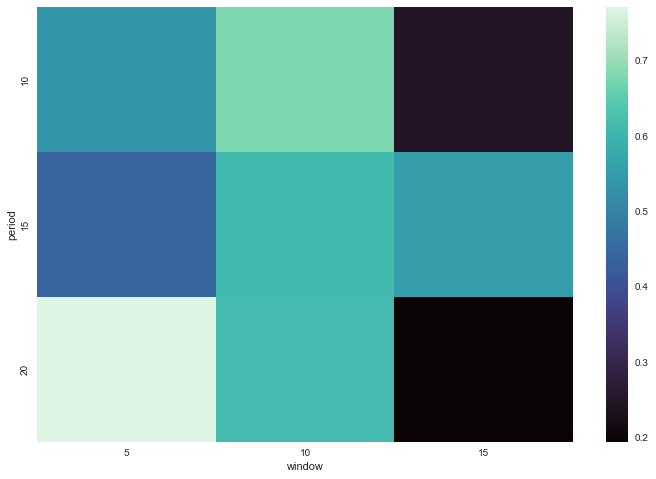

In [47]:

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 8))
heatmap_df = opt_df.pivot(index='period', columns='window', values='calmar_ratio')
sns.heatmap(heatmap_df, cmap='mako')

plt.savefig('./images/opt_heatmap.png')
plt.show()

In [ ]:
annual_rets = pd.Series(strats.analyzers._Return.get_analysis())
annual_sharpe = strats.analyzers._Sharpe.get_analysis()['sharperatio']
dd = strats.analyzers._TimeDrawDown.get_analysis()['maxdrawdown']
day_ret_max = pd.Series(strats.analyzers._TimeReturn.get_analysis()).describe()['max']
day_ret_min = pd.Series(strats.analyzers._TimeReturn.get_analysis()).describe()['min']

results_dict = {
    "夏普比率": sharpe,
    "最大回撤": max_drawdown,
    "累计收益率": cumrets[-1],
    "年化收益率": annual_rets['rnorm'],
    "收益回撤比": annual_rets['rnorm'] / -max_drawdown,
    "单日最大收益": day_ret_max,
    "单日最大亏损": day_ret_min,
    "交易次数": round(rets.shape[0], 0),
    "获胜次数": round(sum(rets > 0), 0),
    "胜率": sum(rets > 0) / rets.shape[0],
    "盈亏比": abs(mean_per_win / mean_per_loss),
}

results_df = pd.Series(results_dict)
# results_df.to_clipboard()
results_df

## 可视化分析

In [ ]:
plt.style.use('ggplot')
# Line plot of timereturn
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1 = cumrets.plot(rot=45, grid=False, label='累计收益率', color='brown', linewidth=3)

ax2 = ax1.twinx()
ax2 = drawdown.plot.area(grid=False, label='回撤情况', alpha=0.4, color='tab:blue', linewidth=2)

ax1.set_ylabel('累计收益率')
# ax2.set_ylabel('回撤情况')
ax1.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks_position('right')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, ncol=1, loc='upper right')
plt.title('IF累计收益和最大回撤曲线')
plt.margins(x=0)
fig.tight_layout()

plt.show()

In [ ]:
# Line plot of rets/prices
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_ylabel('累计收益率')
cumrets.plot(ax=ax1, grid=False, rot=45, label='累计收益率', color='brown', linewidth=3)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
# ax2.set_ylabel('Price')
df['S_DQ_ADJCLOSE'].loc[var.fromdate:var.todate].plot(ax=ax2, color='tab:blue', linewidth=3, grid=False, label=var.contract)
ax2.tick_params(axis='y')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, fontsize=12, ncol=1, loc='upper left')
plt.title('累计收益率和价格曲线')
plt.margins(x=0)
fig.tight_layout()
plt.show()

In [ ]:
# 净值曲线
fig, ax = plt.subplots(figsize=(12, 8))
ax = (cumrets - 1).plot(rot=45, grid=False, label='累计收益率', color='brown', linewidth=3)

ax.set_ylabel('净值曲线(¥)')

plt.margins(x=0)
plt.grid(False)
fig.tight_layout()
plt.show()